# Active Network Management Framework

This notebook stands as a tutorial and as a showcase of the Python package we developped in order to promote the development of computational techniques for Active Network Management (ANM). ANM strategies rely on short-term policies that control the power injected by generators and/or taken off by loads in order to avoid congestion or voltage issues.

The generic formulation of the ANM problem is motivated and described in [this paper](http://arxiv.org/pdf/1405.2806.pdf), which details also the procedure used for building the test case that is provided in the package.

## 1. Simulator's basics

The main class of the package is `Simulator`. This class has a single mandatory parameter that is the data structure defining the **case** (i.e. the distribution system) on which the simulation will be performed.
The package has a predefined case that is located in *case75.py*.

In addition, to ensure reproducibility, a specific random number generator will provided to the simulator.

In [2]:
from ANM import Simulator
from case75 import case75
from numpy.random import RandomState

sim = Simulator(case75(), rng=RandomState(987654321))

An instance of `Simulator` has several member variables that describes the `case`:

In [3]:
print "The distribution network has %d buses (i.e. nodes) and %d branches (i.e. links)." % (sim.N_buses,sim.N_branches)
print "The network supplies %d loads and gathers the production of %d generators." % (sim.N_loads, sim.N_gens)
print "The control means consist in %d flexible loads (%.1f%%) and %d curtailable generators (%.1f%%)." \
      % (sim.N_flex, 100.0*sim.N_flex/sim.N_loads, sim.N_curt, 100.0*sim.N_curt/sim.N_gens)

The distribution network has 77 buses (i.e. nodes) and 76 branches (i.e. links).
The network supplies 53 loads and gathers the production of 59 generators.
The control means consist in 22 flexible loads (41.5%) and 6 curtailable generators (10.2%).


## 2. Stochastic models and power functions

By default, the simulator uses the callables defined in *models.py* to sample sequences of wind speeds and solar irradiances. These models can be overridden by specifying the keyword parameters `wind` and `sun`. Similarly, `case75` relies on a callable defined in *models.py* to genere sequences of load consumptions.

The power functions, which defines the production of generators as a function of the wind speed and solar irradiance, are defined within the `case`. As an example, the power function of photovoltaïc generators has the following definition in `case75.py`:
```
for gen, scale in zip(pv_gens,pv_scales):
        # *gen* is the id of the device (see case75.py)
        # *scale* models the efficiency and area of the generator
        case["power"] += [[gen, lambda ir, ws, scale=scale: scale*ir]] # Add a power function to the case
```

The duration of a time step depends on the stochastic models and on the case, each time step corresponds to 15 minutes in the considered example. Here are the overall active power consumption and production within the network over a 1-day-long simulation, such sa determined by the **seed**, the **stochastic models**, the **devices** (i.e. loads and generators) and their corresponding **power functions**:

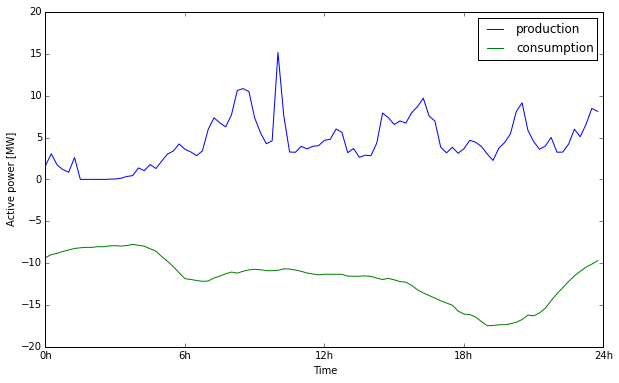

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.figsize"] = (10,6)

P_prod, P_cons = [], []
for _ in range(96): # One day long simulation
    P_prod.append(sum([sim.getPGen(gen) for gen in range(sim.N_gens)]))
    P_cons.append(sum([sim.getPLoad(load) for load in range(sim.N_loads)]))
    sim.transition() # Triggers a transition of the simulation (i.e. simulare next time step)

plt.plot(P_prod, label="production")
plt.plot(P_cons, label="consumption")
plt.ylabel("Active power [MW]")
plt.xlabel("Time")
plt.xticks([0, 24, 48, 72, 96], ["0h", "6h", "12h", "18h", "24h"])
plt.xlim([0,96])
_ = plt.legend()

## 3. Power flow analyses

The previous simulation run did not require any power flow analysis. Such an analysis is performed once per time step as soon as a voltage or current magnitude is requested. Let's run a simulation of one day and plot the evolution of the voltage magnitudes:

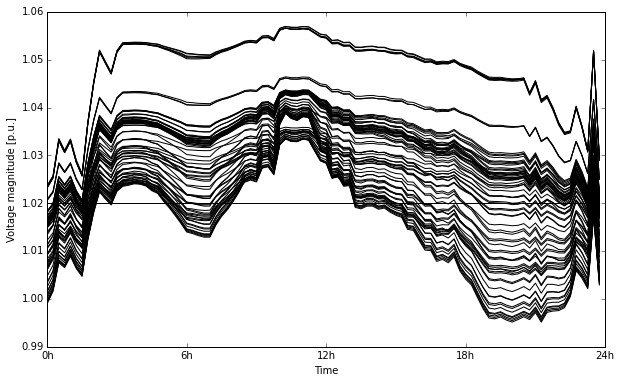

In [5]:
from numpy import array

V = []
for _ in range(96): # One day long simulation
    V.append([sim.getV(bus) for bus in range(sim.N_buses)])
    sim.transition() # Triggers a transition of the simulation (i.e. simulates next time step)

plt.plot(array(V), "k")
plt.ylabel("Voltage magnitude [p.u.]")
plt.xlabel("Time")
plt.xticks([0, 24, 48, 72, 96], ["0h", "6h", "12h", "18h", "24h"])
_ = plt.xlim([0,96])

The constant voltage magnitude corresponds to the slack bus, which models the connection with the transmission network.

## 4. Desicion making

The simulator can be used to assess the quality of a **policy** that, at each time step, decides which flexible loads must be actived and which generators must be curtailed for the following time step. Because both the future of the system is stochastic and the flexible services span over several time periods, we face a problem of **sequential decision making under uncertainty**.

We will now descripte an approach to compute and evaluate a simple and naive policy using the simulator. The approach consists in three steps:
* Run many simuations to build a dataset $\{(P_i,y_i)~|~i = 1,\dots,N\}$ where each point $i$ corresponds to a simulated time step, and such that $P_i$ is equal the overall active power balance within the distribution network: $$P_i = \sum_{l\in\mathrm{generators}} P_{i,g} + \sum_{l\in\mathrm{loads}} P_{i,l}\,,$$ and $y_i$ is a boolean that indicates if the system is secure (i.e. if operational constraints are met).
* Deduce a simple linear rule $P \leq \bar{P}$ to approximate system security as of function of the overall active power balance $P$:
$$ \hat{y} = \begin{cases} 
      1 & \mathrm{if}~P \leq \bar{P}\,, \quad (\mathrm{secure})\\
      0 & \mathrm{otherwise}.
   \end{cases} $$
* To apply the policy, determine, at each time step, curtailment instructions (i.e. upper limits on the production of curtailable generators) based on $N_{trajs}$ samples of the next state of the system (flexible loads are ignored for the sake of simplicity). These samples can be generated by cloning the instance of Simulator.

### 4.1 Building dataset

In [6]:
# Build the dataset
N_sim, L_sim = 5, 192 # 5 runs of 2 days are simulated to build the dataset
dataset = []
rng_dataset = RandomState(6576458)
for _ in range(N_sim):
    # A new instance is required for every simulation run.
    sim_dataset = Simulator(case75(),rng=rng_dataset)
    for _ in range(L_sim):
        # Compute averall active power balance.
        P_i = sum([sim_dataset.getPGen(gen) for gen in range(sim_dataset.N_gens)]) \
            + sum([sim_dataset.getPLoad(load) for load in range(sim_dataset.N_loads)])
        # isSafe() returns True when operational constraints are met, False otherwise
        y_i = sim_dataset.isSafe()
        dataset.append([P_i,y_i])
        sim_dataset.transition()
print "Simulations led to %.1f%% of secure time steps." \
      % (100.0*sum([1 if data[1] else 0 for data in dataset])/len(dataset))

Simulations led to 87.3% of secure time steps.


### 4.2 Determining a linear classifier

The linear classifier is defined by $\bar{P}$, that we determine as:
$$ \bar{P} = 0.95 \cdot \min_i P_i\\\hspace{7em}\text{s.t. }y_i\text{ is False}$$

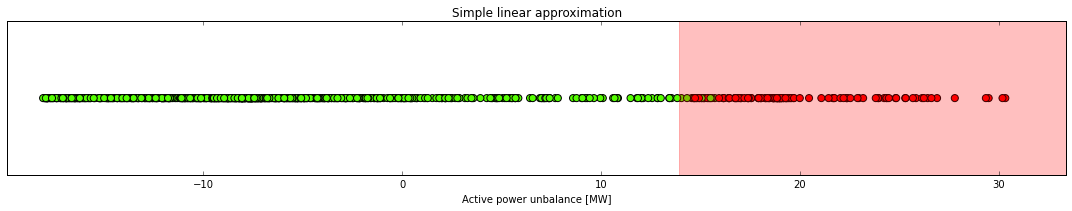

In [7]:
# Determine linear approximator using a 5% margin
P_bar = 0.95*min([d[0] for d in dataset if not d[1]])
# Show approximation
fig = plt.figure(figsize=(15,3))
plt.axvspan(xmin=P_bar, xmax=1.1*max([d[0] for d in dataset]), color="r", alpha=0.25)
plt.scatter([d[0] for d in dataset], [0.0]*len(dataset), c=[float(d[1]) for d in dataset], s=50, cmap="prism")
plt.yticks([])
plt.xlim([1.1*min([d[0] for d in dataset]),1.1*max([d[0] for d in dataset])])
plt.xlabel("Active power unbalance [MW]")
plt.title("Simple linear approximation")
fig.tight_layout()

### 4.3 Test the policy on the simulator

To determine the curtailment for the next time period, we assume that all the curtailable generators will operate at the active power upper limit $P_\max$. This limit is the decision variable that we wish to compute at each time step. As there is a cost (defined in the case) per cutailed MWh, we must determine the largest $P_\max$ that enables operational constraints to be met:
$$
  \begin{alignat*}{2}
    \max \hspace{2em} & P_\max  \\
    \text{s.t.} \hspace{2.25em} & P^{(k)}_{exo} + N_{curt} \, P_\max \leq \bar{P} &,\ & 1\leq k\leq N_{trajs}\,,
  \end{alignat*}
$$
where $P^{(k)}_{exo}$ is, for sampled fututure state $k \in \{1,\dots,N_{trajs}\}$, the overall active power balance without taking into account the injection of curtailable generators. The solution to this linear program is straightfoward:
$$P_\max = \min_k \frac{\bar{P}-P^{(k)}_{exo}}{N_{curt}}\,.$$

We now simulate this policy on a run of 1 day, and then compare with the same simulation run without policy.

In [8]:
from copy import copy, deepcopy

L_simu = 96
N_trajs = 10
rng_trajs = RandomState(3478765)
non_curt_gens = [gen for gen in range(sim.N_gens) if gen not in sim.curtIdInGens]

# record current state to compare simulation with/without the policy
sim_cloned = copy(sim)
sim_cloned = copy(sim)
sim_cloned.wind = copy(sim.wind)
sim_cloned.sun = copy(sim.sun)
sim_cloned.Ploads_fcts = deepcopy(sim.Ploads_fcts)
sim_cloned.rng = deepcopy(sim.rng) # 

P_prod = [] # Gather overall potential production during the simulation
P_curt = [] # Gather overall effictive production (incl. curt.) during the simulation
P_cons = [] # Gather overall consumption during the simulation
V = [] # Gather all voltage magnitudes during the simulation

for _ in range(L_simu):
    # Generate the N_trajs trajectories
    P_exo = []
    for _ in range(N_trajs):
        # Copy the Simulator's instance
        sampler = copy(sim)
        sampler.wind = copy(sim.wind)
        sampler.sun = copy(sim.sun)
        sampler.Ploads_fcts = deepcopy(sim.Ploads_fcts)
        sampler.rng = rng_trajs
        # Simulate a transition
        sampler.transition()
        P_exo.append(sum([sampler.getPGen(gen) for gen in non_curt_gens])+\
                     sum([sampler.getPLoad(load) for load in range(sampler.N_loads)]))

    # Determine the production limit of curtailable generators and apply the control actions
    P_max = min([(P_bar-P)/sim.N_curt for P in P_exo])
    for gen in sim.curtIdInGens:
        sim.setPmax(gen, P_max)
    
    # Simulate a transition
    sim.transition()
    P_prod.append(sum([sim.getPGen(gen) for gen in range(sim.N_gens)]))
    P_curt.append(sum([sim.getPCurtGen(gen) for gen in range(sim.N_gens)]))
    P_cons.append(sum([sim.getPLoad(load) for load in range(sim.N_loads)]))
    V.append([sim.getV(bus) for bus in range(1,sim.N_buses)]) # Range starts at 1 to ignore slack bus


# Simulate the same run without applying the policy
P_prod_free = [] # Gather overall potential production during the simulation
P_cons_free = [] # Gather overall consumption during the simulation
V_free = [] # Gather all voltage magnitudes during the simulation

for _ in range(L_simu):
    # Simulate a transition
    sim_cloned.transition()
    P_prod_free.append(sum([sim_cloned.getPGen(gen) for gen in range(sim_cloned.N_gens)]))
    P_cons_free.append(sum([sim_cloned.getPLoad(load) for load in range(sim_cloned.N_loads)]))
    V_free.append([sim_cloned.getV(bus) for bus in range(1,sim_cloned.N_buses)]) # Range starts at 1 to ignore slack bus

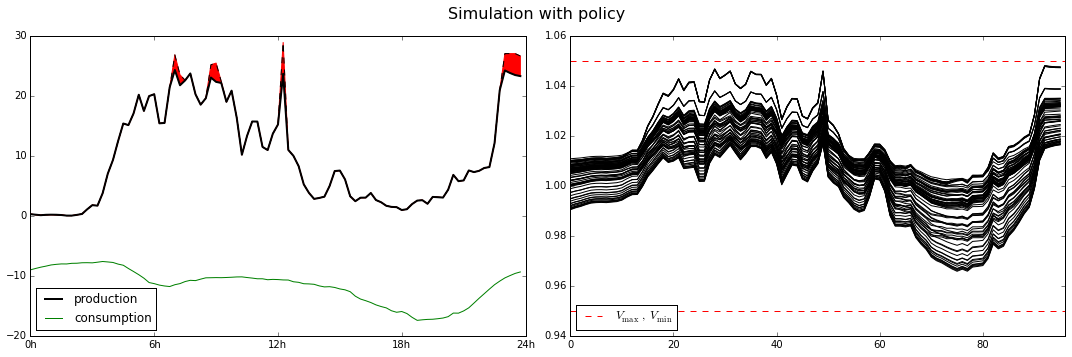

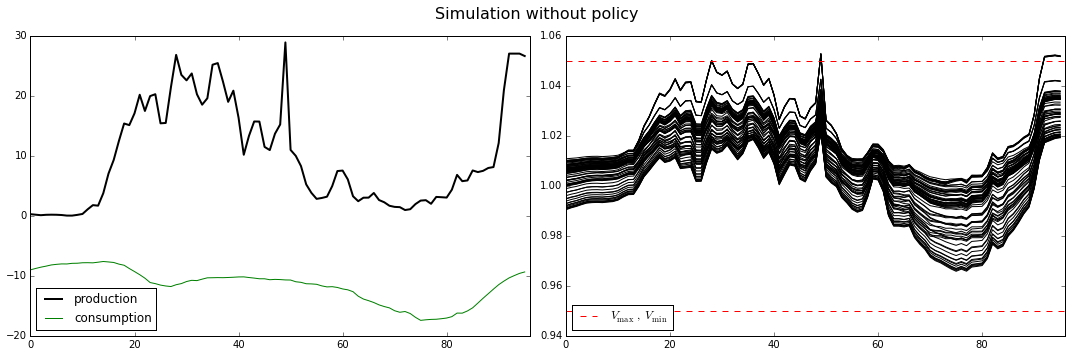

In [9]:
# Plot simulation results with policy
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("Simulation with policy", fontsize=16)
ax1.fill_between(range(L_simu), P_prod, P_curt, color="r")
ax1.plot(P_prod, "k--", label=None)
ax1.plot(P_curt, "k-", lw="2", label="production")
ax1.plot(P_cons, "g", label="consumption")
ax1.legend(loc=3)
ax1.set_xticks([0, 24, 48, 72, 96])
ax1.set_xticklabels(["0h", "6h", "12h", "18h", "24h"])
ax1.set_xlim([0,L_simu])
ax2.plot(V,"k",label=None)
ax2.axhline(y=1.05, color="r", linestyle="--", label="$V_\max\,,\,V_\min$")
ax2.axhline(y=0.95, color="r", linestyle="--")
ax2.set_ylim([0.94,1.06])
ax2.set_xlim([0,L_simu])
ax2.legend(loc=3)
fig.tight_layout()
plt.subplots_adjust(top=0.9)

# Plot simulation results without policy
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("Simulation without policy", fontsize=16)
ax1.plot(P_prod_free, "k-", lw="2", label="production")
ax1.plot(P_cons_free, "g", label="consumption")
ax1.legend(loc=3)
ax1.set_xlim([0,L_simu])
ax2.plot(V_free,"k",label=None)
ax2.axhline(y=1.05, color="r", linestyle="--", label="$V_\max\,,\,V_\min$")
ax2.axhline(y=0.95, color="r", linestyle="--")
ax2.set_ylim([0.94,1.06])
ax2.set_xlim([0,L_simu])
ax2.legend(loc=3)
fig.tight_layout()
plt.subplots_adjust(top=0.9)